In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sys
import torch as pt

sys.path.insert(0, '..')

from function_space import Linear
from problems import LQGC
from solver import Solver
from utilities import do_importance_sampling, plot_loss_logs, plot_solution, save_exp_logs, load_exp_logs

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

# d = 10

In [ ]:
seed = 42

lqgc = LQGC(d=10, off_diag=0.1, T=0.5, seed=seed, delta_t=0.005)

print_every = 500
lr = 0.1 # 0.1 with Adam # 10.0 with SGD
K = 500 
L = 500
delta_t = 0.01
IS_K = 20000

models = [Solver(name='log-variance', problem=lqgc, loss_method='log-variance', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='outer', adaptive_forward_process=True, random_X_0=False),
          Solver(name='moment', problem=lqgc, loss_method='moment', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='outer', adaptive_forward_process=True, random_X_0=False,
                 learn_Y_0=True),
         Solver(name='cross-entropy', problem=lqgc, loss_method='cross_entropy', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='outer', adaptive_forward_process=True, random_X_0=False),
         Solver(name='relative entropy', problem=lqgc, loss_method='relative_entropy', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=False,
                 print_every=print_every, time_approx='outer', adaptive_forward_process=True, random_X_0=False)]

for model in models:
    model.z_n = [Linear(d=model.d, B=pt.eye(model.d).to(model.device), Q=pt.eye(model.d).to(model.device),
                        lr=model.lr, seed=seed) for n in range(model.N)]
    #for z_n in model.z_n:
    #    z_n.optim = pt.optim.SGD(z_n.parameters(), lr=model.lr)
    model.update_Phis()
    model.train()

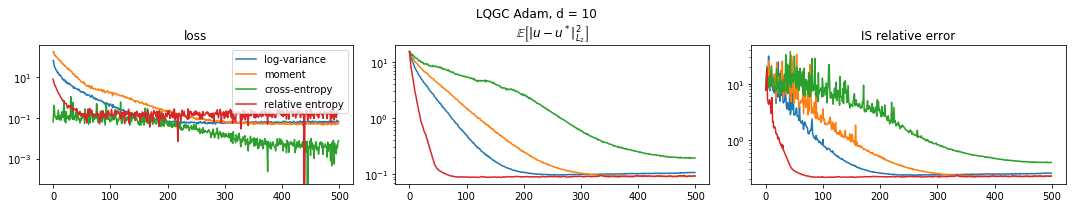

In [13]:
fig = plot_loss_logs('LQGC Adam', models) # lr = 0.1

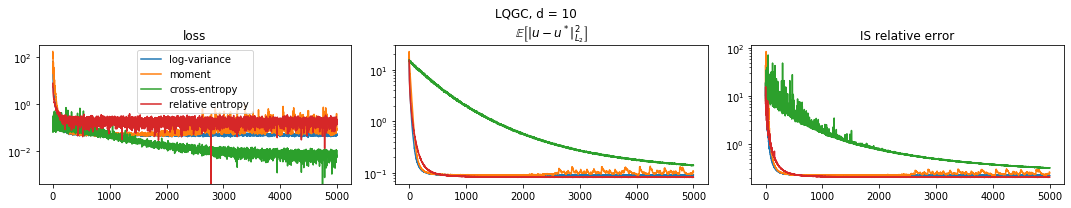

In [6]:
fig = plot_loss_logs('LQGC', models) # lr = 10

In [12]:
#save_exp_logs(models, 'paper/LQGC_d10_Adam')

## random initial value

In [ ]:
seed = 1142

lqgc_d2 = LQGC(d=5, off_diag=0.1, T=0.5, seed=seed, delta_t=0.005)

print_every = 100
lr = 0.1
K = 500 
L = 200
delta_t = 0.01
IS_K = 20000

models_rand_x_0 = [Solver(name='relative entropy', problem=lqgc_d2, loss_method='relative_entropy', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=False,
                 print_every=print_every, time_approx='outer', adaptive_forward_process=True, random_X_0 = True),
         Solver(name='relative entropy', problem=lqgc_d2, loss_method='relative_entropy', L=L, lr=lr, seed=seed,
                 delta_t=delta_t, K=K, IS_variance_K=IS_K, plot_trajectories=None, detach_forward=False,
                 print_every=print_every, time_approx='outer', adaptive_forward_process=True)]

for model in models_rand_x_0:
    model.z_n = [Linear(d=model.d, B=pt.eye(model.d).to(model.device), Q=pt.eye(model.d).to(model.device), 
                        lr=model.lr, seed=seed) for n in range(model.N)]
    model.update_Phis()
    model.train()

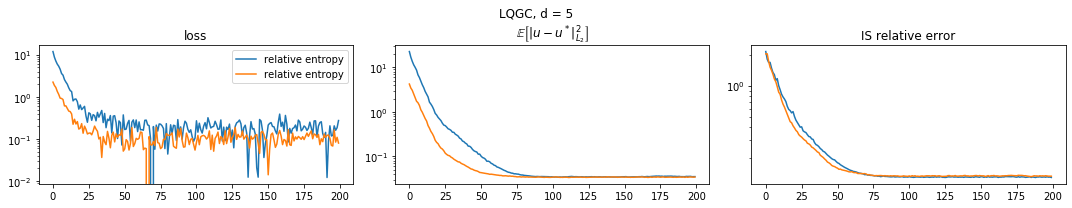

In [18]:
fig = plot_loss_logs('LQGC', models_rand_x_0)

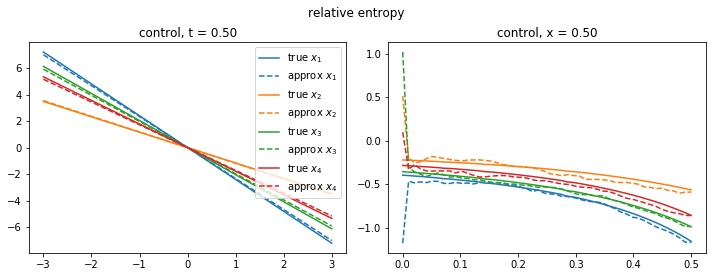

In [20]:
fig = plot_solution(models_rand_x_0[1], x=.5, t=0.5, components=[0, 1, 2, 3])

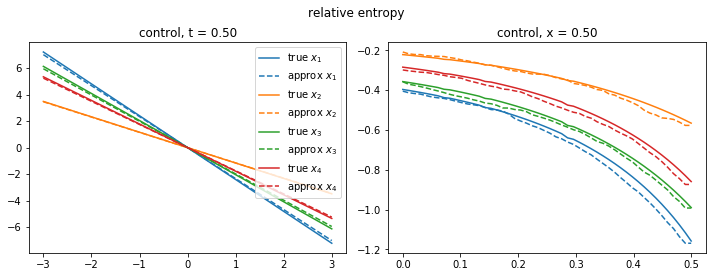

In [21]:
fig = plot_solution(models_rand_x_0[0], x=.5, t=0.5, components=[0, 1, 2, 3])

## Plots for paper

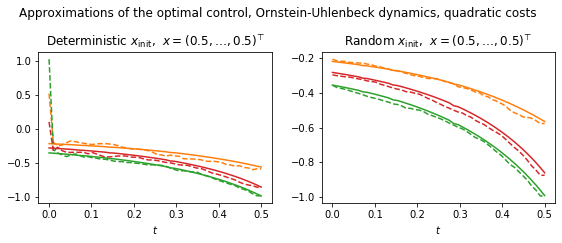

In [4]:
COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
          'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

ylims = None

model_1 = models_rand_x_0[1]
model_2 = models_rand_x_0[0]
components = [1, 2, 3]

x = 0.5
t = 0
n = int(np.ceil(t / model.delta_t_np))
t_range = np.linspace(0, model.T, model.N)
X = pt.autograd.Variable(pt.tensor([[x] * model.d]), requires_grad=True).to(device)


fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

fig.suptitle(r'Approximations of the optimal control, Ornstein-Uhlenbeck dynamics, quadratic costs')

ax[0].set_title(r'Deterministic $x_{\mathrm{init}}$,  $x = (%.1f, \dots, %.1f)^\top$' % (x, x))
for j in components:
    if model_1.u_true(X.cpu().detach(), n * model.delta_t_np) is not None:
        ax[0].plot(t_range, [model_1.u_true(X.cpu().detach(), n * model_1.delta_t_np)[j].item() for n in
                             range(model_1.N)], label=r'true $x_%d$' % (j + 1), color=COLORS[j])
    ax[0].plot(t_range, [-model_1.Z_n(X, t)[0, j].item() for t in t_range], '--',
               label=r'approx $x_%d$' % (j + 1), color=COLORS[j])
if ylims is not None:
    ax[0].set_ylim(ylims[1][0], ylims[1][1])
ax[0].set_xlabel(r'$t$')

ax[1].set_title(r'Random $x_{\mathrm{init}}$,  $x = (%.1f, \dots, %.1f)^\top$' % (x, x))
for j in components:
    if model_2.u_true(X.cpu().detach(), n * model_2.delta_t_np) is not None:
        ax[1].plot(t_range, [model_2.u_true(X.cpu().detach(), n * model_2.delta_t_np)[j].item() for n in
                             range(model_2.N)], label=r'true $x_%d$' % (j + 1), color=COLORS[j])
    ax[1].plot(t_range, [-model_2.Z_n(X, t)[0, j].item() for t in t_range], '--',
               label=r'approx $x_%d$' % (j + 1), color=COLORS[j])
if ylims is not None:
    ax[1].set_ylim(ylims[1][0], ylims[1][1])
ax[1].set_xlabel(r'$t$');
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
#fig.savefig('img/deterministic_vs_random_x_0_LQGC.pdf')

In [19]:
#save_exp_logs(models, 'paper/LQGC_d10_adam')

In [4]:
exp_logs_adam = load_exp_logs('paper/LQGC_d10_Adam_2020-04-30.json')
exp_logs_SGD = load_exp_logs('paper/LQGC_d10_SGD_2020-04-26.json')

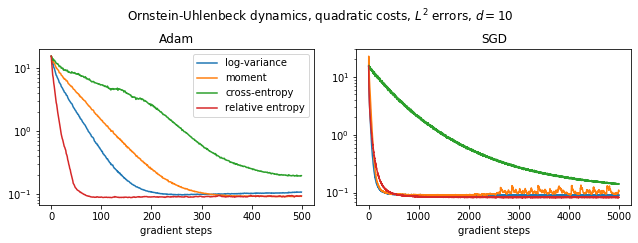

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))
fig.suptitle(r'Ornstein-Uhlenbeck dynamics, quadratic costs, $L^2$ errors, $d = 10$')

for model_name in exp_logs_adam:
    ax[0].plot(exp_logs_adam[model_name]['u_L2_loss'], label=model_name)
    ax[1].plot(exp_logs_SGD[model_name]['u_L2_loss'][:5000])
ax[0].set_yscale('log')
ax[0].set_title('Adam')
ax[1].set_yscale('log')
ax[1].set_title('SGD')
ax[0].legend()
ax[0].set_xlabel('gradient steps')
ax[1].set_xlabel('gradient steps')

fig.tight_layout(rect=[0, 0.03, 1, 0.92])
#fig.savefig('img/LQGC_d10_adam_sgd.pdf')